# Analysis of Bayesian and Random Forest Models on OSHA Exposure Data

**Date:** June 25, 2024 <br>
**Author:** Jacob Kvasnicka

The goal of this analysis is to replicate the original methodology in predicting air concentrations of chemicals using the OSHA data but involving a model that's less computationally intensive than the Bayesian hierarchical model. This comparison aims to determine if similar performance can be achieved with less complexity and computational demand. 

Initially, the performance metrics seem promising, indicating that the model performs comparably to the Bayesian model with high accuracy and low RMSE. However, further investigation suggests that the performances of both models might be artificially high, likely because of how the dataset was prepared:
1. **Duplicate Values**: The dataset shows a significant number of duplicate values, the cause of which is unclear.
2. **Data Leakage**:  Preprocessing steps like centering and scaling were conducted on the entire dataset prior to splitting, and a substantial portion of the test set data is also found in the training set. Essentially, the model was mostly evaluated on data it was trained on.

## Description and Comparison of Model Approaches

As an alternative to the Bayesian approach, I implemented a two-stage Random Forests approach, maintaining the exact training and test sets used in the Bayesian approach. The first stage classifies whether a sample has a detectable concentration, while the second stage predicts the concentration levels for those detectable samples.

A key difference between the Bayesian model and the Random Forest is how the NAICS codes are incorporated. The original Bayesian model directly models  hierarchical effects to manage variability across different subsectors within sectors. In contrast, the Random Forest model does not directly model hierarchical effects but includes the one-hot-encoded subsectors as features alongside the physical-chemical property estimates.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

In [2]:
# Load data files
osha_full = pd.read_csv('../ht_occupational-1.0.0/output/osha_processed_full.csv')
osha_train = pd.read_csv('../ht_occupational-1.0.0/output/osha_processed_training.csv')
osha_test = pd.read_csv('../ht_occupational-1.0.0/output/osha_processed_test.csv')

C:\Users\jmank\AppData\Local\Temp\ipykernel_14732\2868573236.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  osha_full = pd.read_csv('../ht_occupational-1.0.0/output/osha_processed_full.csv')
C:\Users\jmank\AppData\Local\Temp\ipykernel_14732\2868573236.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  osha_train = pd.read_csv('../ht_occupational-1.0.0/output/osha_processed_training.csv')


In [3]:
# Define data configuration settings
data_config = {
    'phys_chem_cols' : [
        'logp_pred', 
        'bp_pred', 
        'loghl_pred', 
        'rt_pred', 
        'logoh_pred', 
        'logkoc_pred'
    ],
    'naics_col' : 'naics_unified',
    'class_target_col' : 'detected',
    'reg_target_col' : 'conc_mgm3',
}

## Model Performance Comparison

In [4]:
def train_evaluate_classifier(
        osha_train, 
        osha_test, 
        phys_chem_cols, 
        naics_col,
        osha_full,
        target_col
    ):
    '''
    Train and evaluate a RandomForestClassifier on binary classification data.

    Parameters
    ----------
    osha_train : pd.DataFrame
        Training dataset containing features and target.
    osha_test : pd.DataFrame
        Test dataset containing features and target.
    phys_chem_cols : list
        List of column names to be used as features for the model.

    Returns
    -------
    tuple
        Training and test accuracy scores.
    '''
    X_train, y_train = prepare_classification_data(
        osha_train, 
        phys_chem_cols, 
        naics_col,
        osha_full,
        target_col
    )
    X_test, y_test = prepare_classification_data(
        osha_test, 
        phys_chem_cols, 
        naics_col,
        osha_full,
        target_col
    )

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    y_pred_class_train = clf.predict(X_train)
    y_pred_class_test = clf.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_pred_class_train)
    accuracy_test = accuracy_score(y_test, y_pred_class_test)

    return accuracy_train, accuracy_test

def train_evaluate_regressor(
        osha_train, 
        osha_test, 
        phys_chem_cols, 
        naics_col, 
        osha_full,
        target_col
    ):
    '''
    Train and evaluate a RandomForestRegressor on detected samples for regression.

    Parameters
    ----------
    osha_train : pd.DataFrame
        Training dataset containing features and target.
    osha_test : pd.DataFrame
        Test dataset containing features and target.
    phys_chem_cols : list
        List of column names to be used as features for the model.

    Returns
    -------
    tuple
        Training and test RMSE scores.
    '''
    X_train, y_train = prepare_regression_data(
        osha_train, 
        phys_chem_cols, 
        naics_col,
        osha_full,
        target_col
    )
    X_test, y_test = prepare_regression_data(
        osha_test, 
        phys_chem_cols, 
        naics_col,
        osha_full,
        target_col
    )

    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train, y_train)

    y_pred_reg_train = reg.predict(X_train)
    y_pred_reg_test = reg.predict(X_test)

    rmse_train = mean_squared_error(y_train, y_pred_reg_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_reg_test, squared=False)

    return rmse_train, rmse_test

def prepare_classification_data(
        osha_data, 
        phys_chem_cols, 
        naics_col, 
        osha_full,
        target_col,
        combine_Xy=False
    ):
    '''
    Prepare binary classification data.
    '''
    X = prepare_features(osha_data, phys_chem_cols, naics_col, osha_full)
    y = osha_data[target_col]

    return prepare_features_and_target(X, y, combine_Xy)
        
def prepare_regression_data(
        osha_data, 
        phys_chem_cols, 
        naics_col, 
        osha_full,
        target_col,
        combine_Xy=False
    ):
    '''
    Prepare regression data for detected samples.
    '''
    X = prepare_features(osha_data, phys_chem_cols, naics_col, osha_full)

    # Filter out non-detect values
    where_detected = osha_data['detected'] == 1
    y = np.log10(osha_data.loc[where_detected, target_col])
    X = X.loc[y.index]

    return prepare_features_and_target(X, y, combine_Xy)

def prepare_features_and_target(X, y, combine_Xy=False):
    '''
    '''
    if combine_Xy:
        return pd.concat([X, y], axis=1)
    else:
        return X, y
        
def prepare_features(osha_data, phys_chem_cols, naics_col, osha_full):
    '''
    '''
    X_phys_chem = osha_data[phys_chem_cols]
    X_naics = prepare_naics_features(osha_data, naics_col)
    # For backwards compatibility, this is used to get consistent columns
    all_categories = prepare_naics_features(osha_full, naics_col).columns
    X_naics = X_naics.reindex(columns=all_categories, fill_value=0.)
    return pd.concat([X_phys_chem, X_naics], axis=1)
    
def prepare_naics_features(osha_data, naics_col):
    '''
    For backwards compatibility, the 
    '''
    subsector_series = osha_data[naics_col].str[:3] 
    return pd.get_dummies(subsector_series)  # one-hot encode
    
def plot_model_performance(classification_accuracies, regression_rmses, models):
    '''
    Plot a comparison of model performance scores between Bayesian and Random Forest approaches.

    Parameters
    ----------
    classification_accuracies : list
        List containing classification accuracy scores for Bayesian and Random Forest approaches.
    regression_rmse : list
        List containing regression RMSE scores for Bayesian and Random Forest approaches.
    models : list of str
        List of model names in the same order as the other inputs.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].bar(models, classification_accuracies, color=['blue', 'orange'])
    ax[0].set_title('Classification Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim(0, 1)

    ax[1].bar(models, regression_rmses, color=['blue', 'orange'])
    ax[1].set_title('Regression RMSE')
    ax[1].set_ylabel('RMSE')

    plt.tight_layout()
    plt.show()

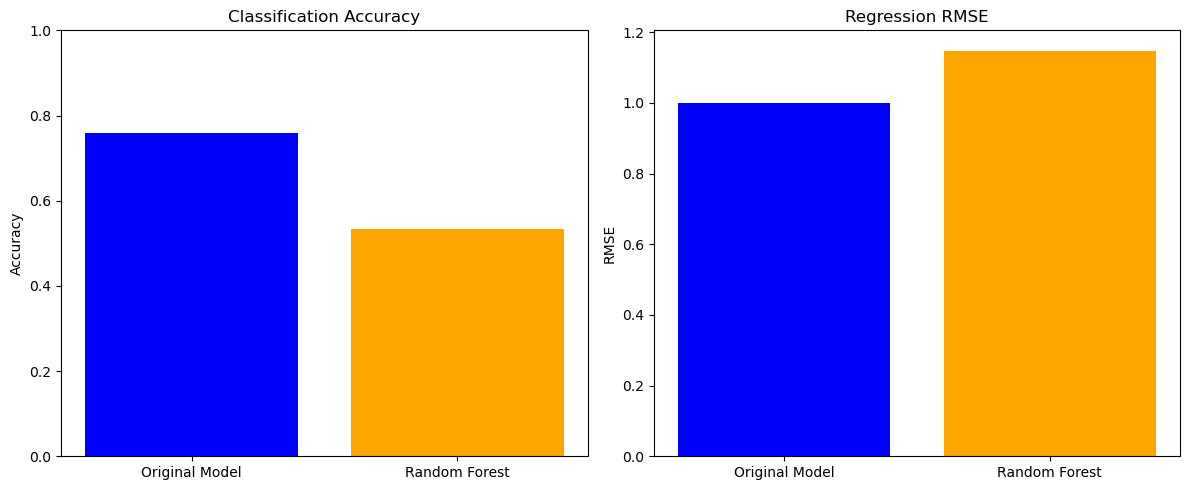

In [5]:
accuracy_train, accuracy_test = train_evaluate_classifier(
    osha_train, 
    osha_test, 
    data_config['phys_chem_cols'], 
    data_config['naics_col'],
    osha_full,
    data_config['class_target_col']
)
rmse_train, rmse_test = train_evaluate_regressor(
    osha_train, 
    osha_test, 
    data_config['phys_chem_cols'], 
    data_config['naics_col'],
    osha_full,
    data_config['reg_target_col']
)

classification_accuracies = [
    0.759,  # Minucci et al., 2023
    accuracy_test
]
regression_rmses = [
    1.0,  # Minucci et al., 2023
    rmse_test
]
models = ['Original Model', 'Random Forest']
plot_model_performance(classification_accuracies, regression_rmses, models)

### Interpretation
Implementing the two-stage Random Forest approach yields similar performance as the Bayesian model with a 10-fold reduction in the execution time. However, further investigation below reveals that the performances of both models may be overestimated because of underlying issues in data preparation.

## Check for Duplicated Values
According to the paper, my expectation was that the input data should have been aggregated by inspection number, particularly using the maximum concentration value across samples for a given inspection number. However, the observations below suggest that the intended aggregation by inspection number in the original code may not have been fully effective.

In [6]:
def analyze_duplicates(dataframe):
    '''
    Return the percentage of duplicate rows in a dataframe.

    Parameters
    ----------
    dataframe : pd.DataFrame
        The dataframe to analyze for duplicates.
    '''
    total_duplicates = dataframe.duplicated().sum()

    proportion_duplicates = total_duplicates / len(dataframe)

    return proportion_duplicates * 100

In [7]:
print(f'{round(analyze_duplicates(osha_full))}% of all samples are duplicates')

13% of all samples are duplicates


In [8]:
Xy_train_class = prepare_classification_data(
    osha_train,
    data_config['phys_chem_cols'], 
    data_config['naics_col'],
    osha_full,
    data_config['class_target_col'],
    combine_Xy=True
)
print(f'{round(analyze_duplicates(Xy_train_class))}% of classification training samples are identical')

87% of classification training samples are identical


In [9]:
Xy_test_class = prepare_classification_data(
    osha_test,
    data_config['phys_chem_cols'], 
    data_config['naics_col'],
    osha_full,
    data_config['class_target_col'],
    combine_Xy=True
)
print(f'{round(analyze_duplicates(Xy_test_class))}% of classification test samples are identical')

88% of classification test samples are identical


In [10]:
Xy_train_reg = prepare_regression_data(
    osha_train,
    data_config['phys_chem_cols'], 
    data_config['naics_col'],
    osha_full,
    data_config['reg_target_col'],
    combine_Xy=True
)
print(f'{round(analyze_duplicates(Xy_train_reg))}% of regression training samples are identical')

14% of regression training samples are identical


In [11]:
Xy_test_reg = prepare_regression_data(
    osha_test,
    data_config['phys_chem_cols'], 
    data_config['naics_col'],
    osha_full,
    data_config['reg_target_col'],
    combine_Xy=True
)
print(f'{round(analyze_duplicates(Xy_test_reg))}% of regression test samples are identical')

0% of regression test samples are identical


The root cause of the duplicates in the full dataset is not entirely clear. The duplicates in the training and test sets were likely propagated from the full dataset and, for the classification model, might also include cases where the same chemical was sampled across different companies within the same subsector and yielded consistent detect or non-detect results.

### Potential Implications
- The training process could be biased towards these repeated data points, potentially leading to overfitting.
- In practice, such a model might underperform when given new data.

## Check for Data Leakage
By inspecting the original code, not shown here, I noticed that preprocessing steps like centering and scaling were conducted on the entire dataset prior to splitting into training and test sets. This inadvertently incorporated test set information into the model training process.

The code below checks for any samples that are present in both the training and test sets.

In [12]:
def count_overlapping_samples(train_df, test_df):
    '''
    Check for overlapping samples between training and test sets. 
    
    A single identifier is created by joining all column values as strings.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training dataset containing features and target.
    test_df : pd.DataFrame
        Test dataset containing features and target.

    Returns
    -------
    int
        The number of overlapping samples between the training and test sets.
    '''
    train_df, test_df = train_df.copy(), test_df.copy()
    
    train_df['combined'] = train_df.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    test_df['combined'] = test_df.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

    train_set = set(train_df['combined'])
    test_set = set(test_df['combined'])

    overlap = test_set.intersection(train_set)

    return len(overlap)

In [13]:
overlap_class = count_overlapping_samples(Xy_train_class, Xy_test_class) / len(Xy_test_class) * 100
print(f'{round(overlap_class)}% of classification test samples included in training set')

0% of classification test samples included in training set


In [14]:
overlap_reg = count_overlapping_samples(Xy_train_reg, Xy_test_reg) / len(Xy_test_reg) * 100
print(f'{round(overlap_reg)}% of regression test samples included in training set')

0% of regression test samples included in training set


### Potential Implications
- These issues likely inflate the accuracy and RMSE metrics, as the model is evaluated on data it has already seen during training.
- Consequently, the model's effectiveness in real-world predictive scenarios may be overestimated.

## Summary and Reflections

While the original Bayesian model is sophisticated and innovative, the findings suggest that its estimated performance could be significantly optimistic because of how the data were prepared. Addressing these issues could involve:
- Implementing more rigorous data cleaning, perhaps following Lavoué et al., 2023
- Implementing a cross-validation setup, rather than a single train-test split, to more fully gauge the model's prediction error across multiple partitions to the dataset